In [35]:
# !python --version

import os
import pandas as pd
import xarray as xr
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pickle as pkl
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Ensure the files exist
file_paths = [
    "data/dwd_icon_eu_pes10_20231027_20240108.nc",
    "data/dwd_icon_eu_hornsea_1_20231027_20240108.nc",
    "data/dwd_icon_eu_demand_20231027_20240108.nc",
    "data/Energy_Data_20200920_20231027.csv",
    "data/Energy_Data_20200920_20240118.csv"
]

for file_path in file_paths:
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")


In [41]:
# Load and preprocess data for 2020-2023
dwd_Hornsea1 = xr.open_dataset("data/dwd_icon_eu_hornsea_1_20200920_20231027.nc")
dwd_Hornsea1_features = dwd_Hornsea1["WindSpeed:100"].mean(dim=["latitude", "longitude"]).to_dataframe().reset_index()
dwd_Hornsea1_features["ref_datetime"] = dwd_Hornsea1_features["ref_datetime"]
dwd_Hornsea1_features["valid_datetime"] = dwd_Hornsea1_features["ref_datetime"] + pd.to_timedelta(dwd_Hornsea1_features["valid_datetime"], unit="hours")

dwd_solar = xr.open_dataset("data/dwd_icon_eu_pes10_20200920_20231027.nc")
dwd_solar_features = dwd_solar["SolarDownwardRadiation"].mean(dim="point").to_dataframe().reset_index()
dwd_solar_features["ref_datetime"] = dwd_solar_features["ref_datetime"]
dwd_solar_features["valid_datetime"] = dwd_solar_features["ref_datetime"] + pd.to_timedelta(dwd_solar_features["valid_datetime"], unit="hours")
dwd_solar_features = dwd_solar_features.drop_duplicates(subset="valid_datetime")

energy_data = pd.read_csv("data/Energy_Data_20200920_20231027.csv")
energy_data["dtm"] = pd.to_datetime(energy_data["dtm"])
energy_data["Solar_MWh_credit"] = 0.5 * energy_data["Solar_MW"]

# Ensure timezone consistency
energy_data["dtm"] = energy_data["dtm"].dt.tz_convert("UTC")

# Merge and prepare data for modeling (2020-2023)
modelling_table = dwd_solar_features.set_index("valid_datetime").resample("30T").interpolate("linear").reset_index()
modelling_table["valid_datetime"] = modelling_table["valid_datetime"].dt.tz_localize("UTC")
modelling_table = modelling_table.merge(energy_data, how="inner", left_on="valid_datetime", right_on="dtm")
modelling_table.rename(columns={"SolarDownwardRadiation": "SolarRadiation"}, inplace=True)

# Split data into training (2020-2023)
train_data = modelling_table[modelling_table["valid_datetime"] < "2024-01-01"]

# Separate features and target
X_train, y_train = train_data[["SolarRadiation"]], train_data["Solar_MWh_credit"]

# Remove NaNs from y_train
X_train = X_train[~y_train.isna()]
y_train = y_train.dropna()

In [42]:
# Train OLS regression model
ols_model = smf.ols('Solar_MWh_credit ~ SolarRadiation', data=train_data).fit()
print(ols_model.summary())

# Save the OLS model using pickle
with open("models/ols_model.pkl", "wb") as file:
    pkl.dump(ols_model, file)

                            OLS Regression Results                            
Dep. Variable:       Solar_MWh_credit   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                 2.690e+05
Date:                Mon, 20 May 2024   Prob (F-statistic):               0.00
Time:                        03:06:09   Log-Likelihood:            -3.1397e+05
No. Observations:               54309   AIC:                         6.280e+05
Df Residuals:                   54307   BIC:                         6.280e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.6482      0.405      4.

In [43]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=0)
rf_model.fit(X_train, y_train)

# Save the Random Forest model
with open("models/rf_model.pkl", "wb") as file:
    pkl.dump(rf_model, file)

In [44]:
# Scale the features for MLP Regressor
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train MLP Regressor with scaled data and increased iterations
mlp_model = MLPRegressor(solver='adam', alpha=1e-5, hidden_layer_sizes=(10, 5), max_iter=1000, learning_rate_init=0.001, random_state=0)
mlp_model.fit(X_train_scaled, y_train)

# Save the MLP model
with open("models/mlp_model.pkl", "wb") as file:
    pkl.dump(mlp_model, file)

/Applications/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [46]:
# Load data for 2024
dwd_Hornsea1_2024 = xr.open_dataset("data/dwd_icon_eu_hornsea_1_20231027_20240108.nc")
dwd_Hornsea1_features_2024 = dwd_Hornsea1_2024["WindSpeed:100"].mean(dim=["latitude", "longitude"]).to_dataframe().reset_index()
dwd_Hornsea1_features_2024["ref_datetime"] = dwd_Hornsea1_features_2024["reference_time"]
dwd_Hornsea1_features_2024["valid_datetime"] = dwd_Hornsea1_features_2024["ref_datetime"] + pd.to_timedelta(dwd_Hornsea1_features_2024["valid_time"], unit="hours")

dwd_solar_2024 = xr.open_dataset("data/dwd_icon_eu_pes10_20231027_20240108.nc")
dwd_solar_features_2024 = dwd_solar_2024["SolarDownwardRadiation"].mean(dim="point").to_dataframe().reset_index()
dwd_solar_features_2024["ref_datetime"] = dwd_solar_features_2024["reference_time"]
dwd_solar_features_2024["valid_datetime"] = dwd_solar_features_2024["ref_datetime"] + pd.to_timedelta(dwd_solar_features_2024["valid_time"], unit="hours")
dwd_solar_features_2024 = dwd_solar_features_2024.drop_duplicates(subset="valid_datetime")

energy_data_2024 = pd.read_csv("data/Energy_Data_20200920_20240118.csv")
energy_data_2024["dtm"] = pd.to_datetime(energy_data_2024["dtm"])
energy_data_2024["Solar_MWh_credit"] = 0.5 * energy_data_2024["Solar_MW"]

# Ensure timezone consistency
energy_data_2024["dtm"] = energy_data_2024["dtm"].dt.tz_convert("UTC")

# Merge and prepare data for 2024
modelling_table_2024 = dwd_solar_features_2024.set_index("valid_datetime").resample("30T").interpolate("linear").reset_index()
modelling_table_2024["valid_datetime"] = modelling_table_2024["valid_datetime"].dt.tz_localize("UTC")
modelling_table_2024 = modelling_table_2024.merge(energy_data_2024, how="inner", left_on="valid_datetime", right_on="dtm")
modelling_table_2024.rename(columns={"SolarDownwardRadiation": "SolarRadiation"}, inplace=True)

# Separate features and target for 2024
X_test_2024, y_test_2024 = modelling_table_2024[["SolarRadiation"]], modelling_table_2024["Solar_MWh_credit"]

# Debug: Print shapes
print("X_test_2024 shape:", X_test_2024.shape)
print("y_test_2024 shape:", y_test_2024.shape)

X_test_2024 shape: (3745, 1)
y_test_2024 shape: (3745,)


In [48]:
# Load models using pickle
with open("models/ols_model.pkl", "rb") as file:
    ols_model = pkl.load(file)
with open("models/rf_model.pkl", "rb") as file:
    rf_model = pkl.load(file)
with open("models/mlp_model.pkl", "rb") as file:
    mlp_model = pkl.load(file)

# Scale the test features for MLP Regressor
X_test_2024_scaled = scaler.transform(X_test_2024)

# Predict with each model
y_pred_ols = ols_model.predict(X_test_2024)
y_pred_rf = rf_model.predict(X_test_2024)
y_pred_mlp = mlp_model.predict(X_test_2024_scaled)

In [49]:
# Evaluate models
def evaluate_model(y_test, y_pred, model_name):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - Mean Squared Error: {mse:.4f}, R^2 Score: {r2:.4f}")

In [50]:
evaluate_model(y_test_2024, y_pred_ols, "OLS Regression")
evaluate_model(y_test_2024, y_pred_rf, "Random Forest Regressor")
evaluate_model(y_test_2024, y_pred_mlp, "MLP Regressor")

OLS Regression - Mean Squared Error: 3198.7718, R^2 Score: 0.6532
Random Forest Regressor - Mean Squared Error: 3447.6975, R^2 Score: 0.6263
MLP Regressor - Mean Squared Error: 3032.6233, R^2 Score: 0.6712


In [51]:
# Save predictions
predictions = pd.DataFrame({
    "date": modelling_table_2024["valid_datetime"],
    "actual": y_test_2024,
    "OLS_Predicted": y_pred_ols,
    "RF_Predicted": y_pred_rf,
    "MLP_Predicted": y_pred_mlp
})
predictions.to_csv("predictions.csv", index=False)
print("Predictions saved to predictions.csv")

Predictions saved to predictions.csv


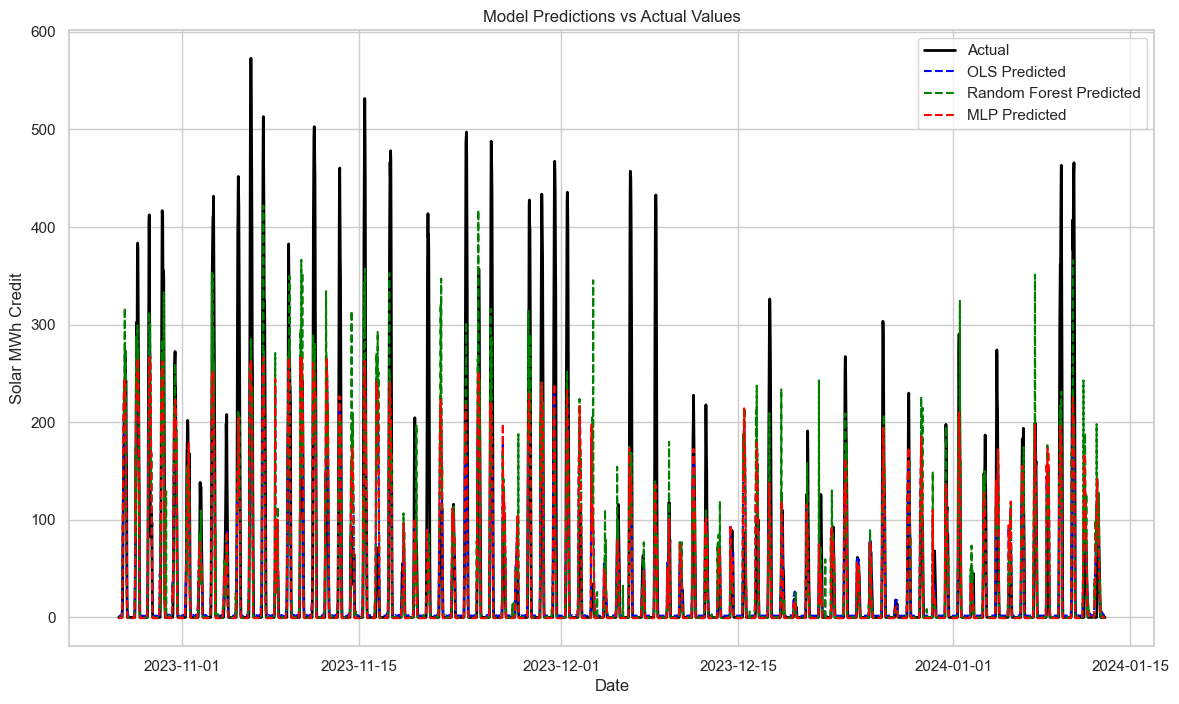

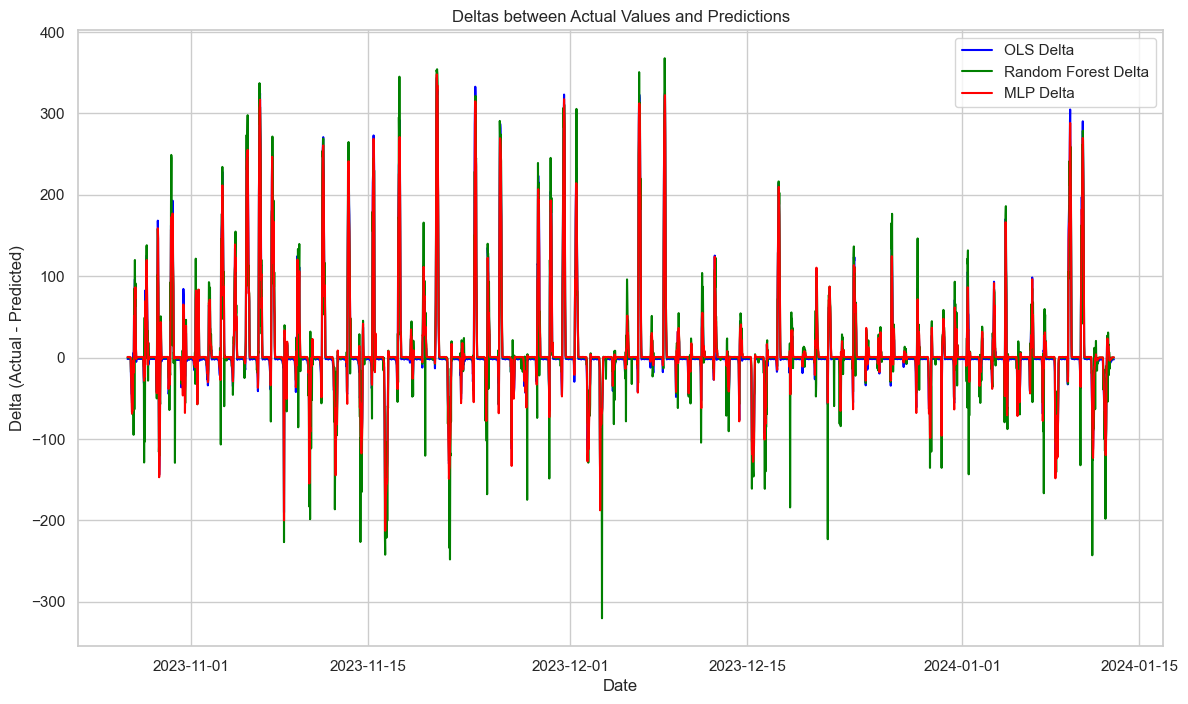

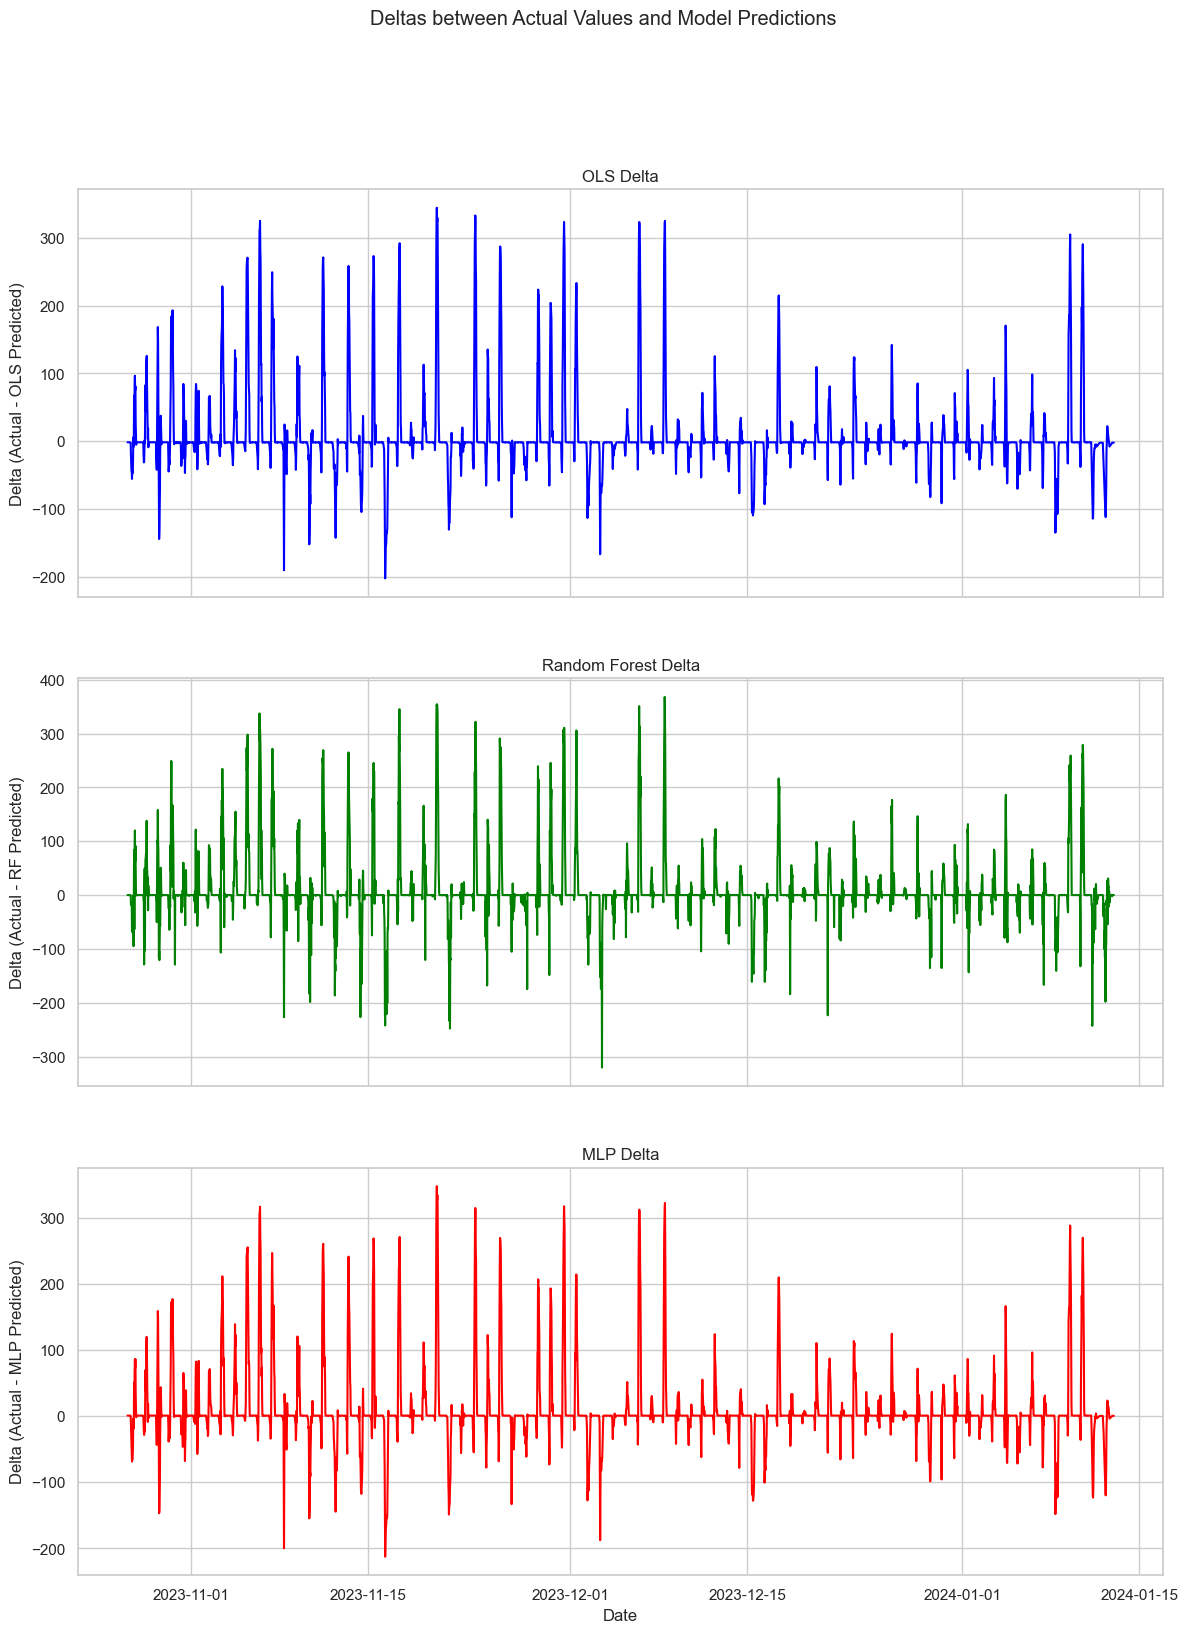

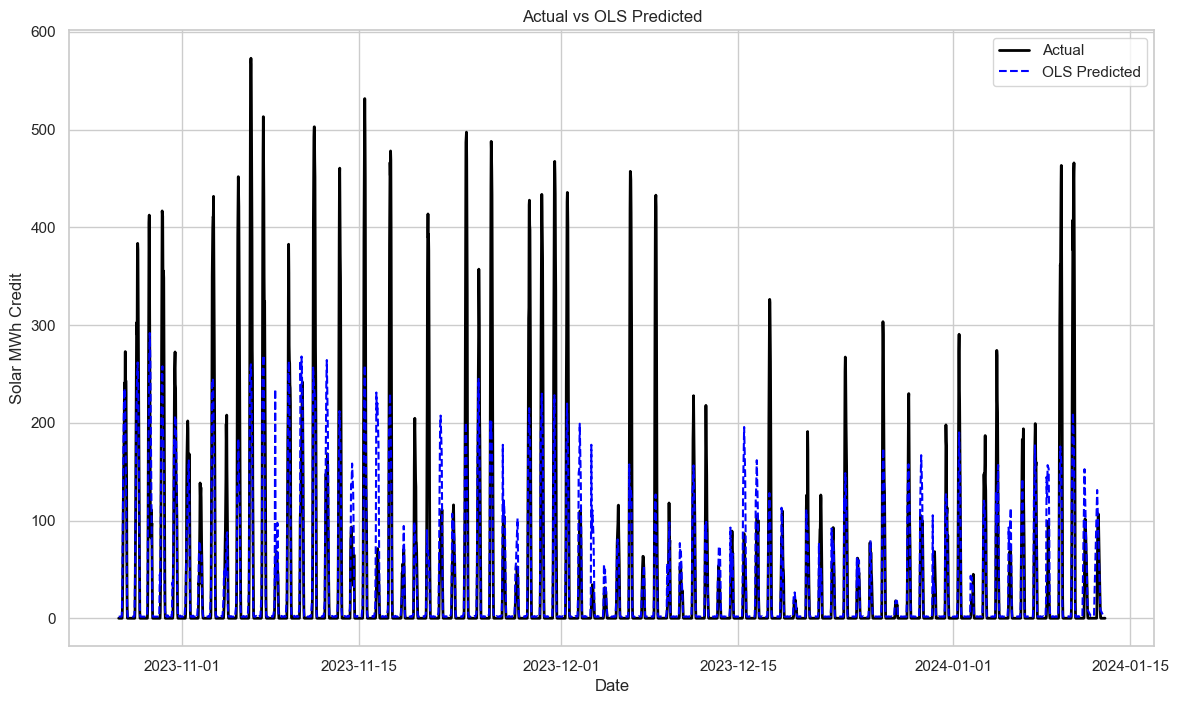

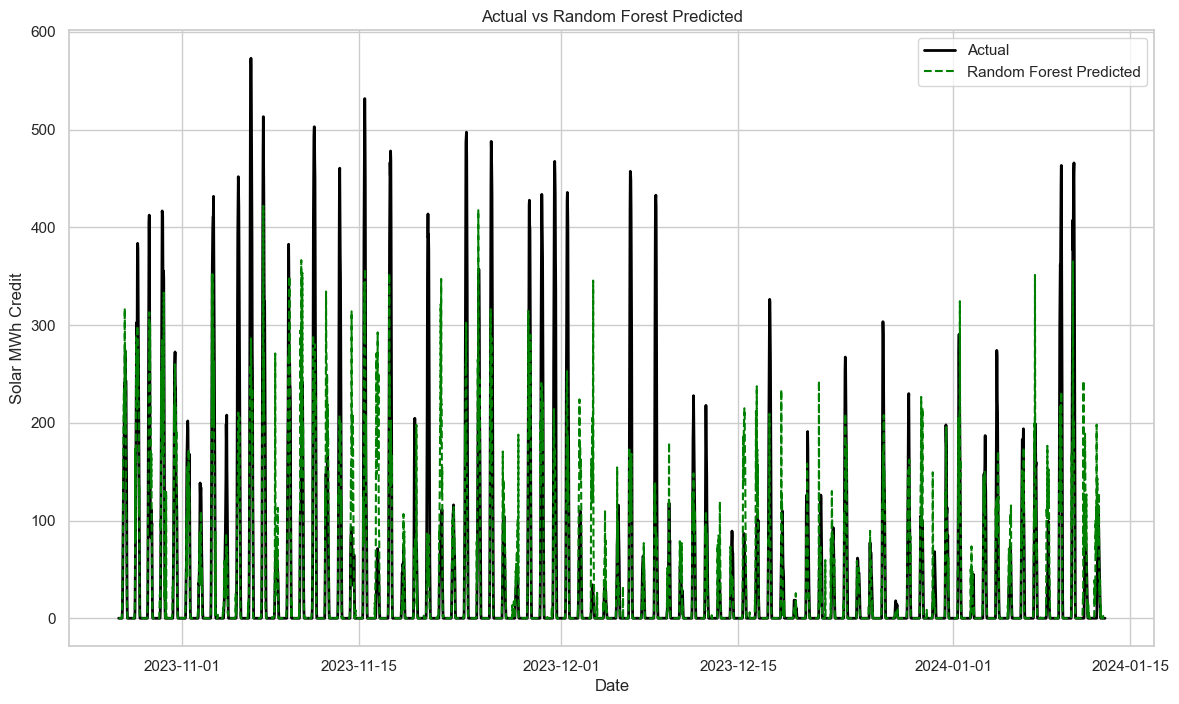

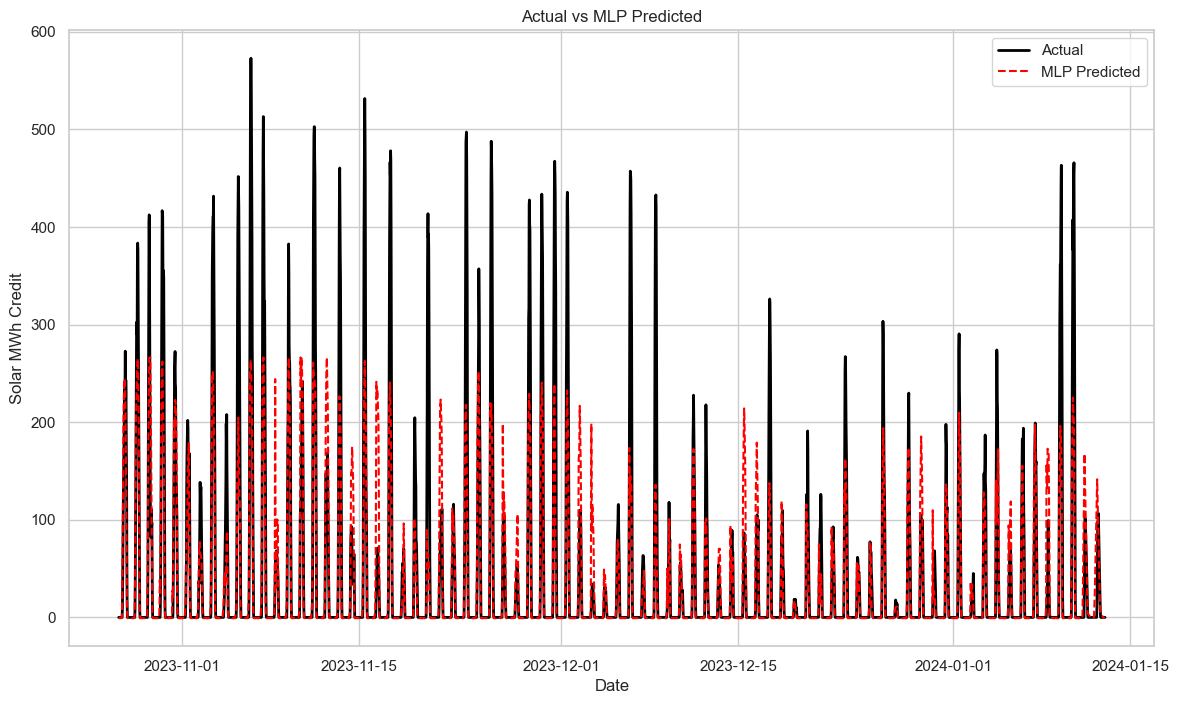

In [52]:
# Plot model predictions against actual values
plt.figure(figsize=(14, 8))
plt.plot(predictions["date"], predictions["actual"], label="Actual", color='black', linewidth=2)
plt.plot(predictions["date"], predictions["OLS_Predicted"], label="OLS Predicted", color='blue', linestyle='--')
plt.plot(predictions["date"], predictions["RF_Predicted"], label="Random Forest Predicted", color='green', linestyle='--')
plt.plot(predictions["date"], predictions["MLP_Predicted"], label="MLP Predicted", color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Solar MWh Credit')
plt.title('Model Predictions vs Actual Values')
plt.legend()
plt.show()

# Plot deltas (differences between actual values and predictions)
plt.figure(figsize=(14, 8))
plt.plot(predictions["date"], predictions["actual"] - predictions["OLS_Predicted"], label="OLS Delta", color='blue')
plt.plot(predictions["date"], predictions["actual"] - predictions["RF_Predicted"], label="Random Forest Delta", color='green')
plt.plot(predictions["date"], predictions["actual"] - predictions["MLP_Predicted"], label="MLP Delta", color='red')
plt.xlabel('Date')
plt.ylabel('Delta (Actual - Predicted)')
plt.title('Deltas between Actual Values and Predictions')
plt.legend()
plt.show()

# Separate delta plots for each model
fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)
fig.suptitle('Deltas between Actual Values and Model Predictions')

# OLS Delta plot
sns.lineplot(ax=axes[0], x=predictions["date"], y=predictions["actual"] - predictions["OLS_Predicted"], color='blue')
axes[0].set_title('OLS Delta')
axes[0].set_ylabel('Delta (Actual - OLS Predicted)')

# Random Forest Delta plot
sns.lineplot(ax=axes[1], x=predictions["date"], y=predictions["actual"] - predictions["RF_Predicted"], color='green')
axes[1].set_title('Random Forest Delta')
axes[1].set_ylabel('Delta (Actual - RF Predicted)')

# MLP Delta plot
sns.lineplot(ax=axes[2], x=predictions["date"], y=predictions["actual"] - predictions["MLP_Predicted"], color='red')
axes[2].set_title('MLP Delta')
axes[2].set_ylabel('Delta (Actual - MLP Predicted)')
axes[2].set_xlabel('Date')

plt.show()

# Plot actual vs OLS prediction
plt.figure(figsize=(14, 8))
plt.plot(predictions["date"], predictions["actual"], label="Actual", color='black', linewidth=2)
plt.plot(predictions["date"], predictions["OLS_Predicted"], label="OLS Predicted", color='blue', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Solar MWh Credit')
plt.title('Actual vs OLS Predicted')
plt.legend()
plt.show()

# Plot actual vs Random Forest prediction
plt.figure(figsize=(14, 8))
plt.plot(predictions["date"], predictions["actual"], label="Actual", color='black', linewidth=2)
plt.plot(predictions["date"], predictions["RF_Predicted"], label="Random Forest Predicted", color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Solar MWh Credit')
plt.title('Actual vs Random Forest Predicted')
plt.legend()
plt.show()

# Plot actual vs MLP prediction
plt.figure(figsize=(14, 8))
plt.plot(predictions["date"], predictions["actual"], label="Actual", color='black', linewidth=2)
plt.plot(predictions["date"], predictions["MLP_Predicted"], label="MLP Predicted", color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Solar MWh Credit')
plt.title('Actual vs MLP Predicted')
plt.legend()
plt.show()